# PySpark Bootcamp Workshop - Day 2

In [5]:
from IPython.display import Image, HTML, SVG, display

In [63]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg")

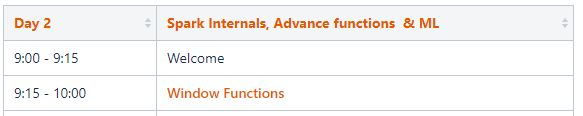

In [64]:

Image(filename="pics/d2_1.JPG")

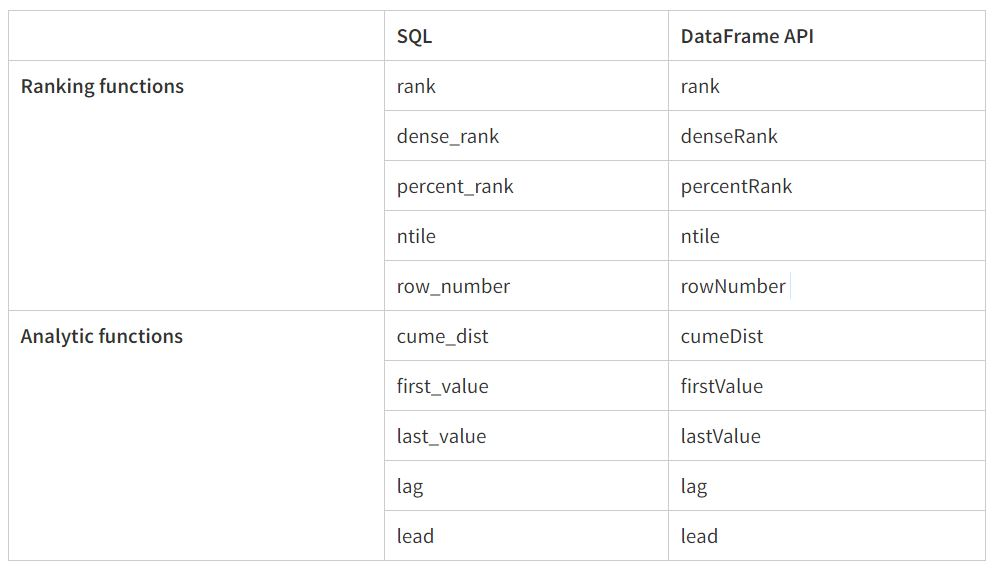

In [65]:
Image(filename="pics/d2_window_1.JPG")

Source:   
https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html  
http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=window#pyspark.sql.Window  

# ***Hands-On session***: 
***spark-python/jupyter-windows/Window Functions Skeleton.ipynb***   
https://github.com/vivek-bombatkar/spark-training/blob/master/spark-python/jupyter-windows/Window%20Functions%20Skeleton.ipynb

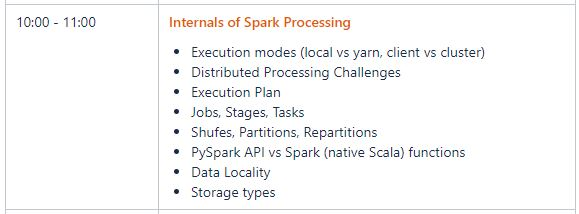

In [66]:
Image(filename="pics/d2_2.JPG")

***Spark application architecture***  
https://blog.cloudera.com/blog/2014/05/apache-spark-resource-management-and-yarn-app-models/  
https://spark.apache.org/docs/latest/cluster-overview.html

In [67]:
Image(url="http://blog.cloudera.com/wp-content/uploads/2014/05/spark-yarn-f1.png")

In [6]:
Image(url="https://spark.apache.org/docs/latest/img/cluster-overview.png")

## Spark Execution Models: 

```
./bin/spark-submit \   
  --class <main-class> \  
  --master <master-url> \  
  --deploy-mode <deploy-mode> \  
  --conf <key>=<value> \  
  ... # other options  
  <application-jar> \  
  [application-arguments]  
```

https://spark.apache.org/docs/2.2.0/submitting-applications.html

In [8]:
from pyspark.sql import SparkSession
from time import gmtime, strftime

TIMESTAMP = strftime("%d%m%Yt%H%M%Sz", gmtime())
app_name = "{}_app_{}".format("vivek",TIMESTAMP) 
print(app_name)

spark = SparkSession.builder \
.master("local[*]") \
.config("spark.submit.deployMode","client") \
.getOrCreate()

# spark.stop()

vivek_app_15062019t141513z


***Cluster Deployment Mode***  
https://www.cloudera.com/documentation/enterprise/5-4-x/topics/cdh_ig_running_spark_on_yarn.html

In [69]:
Image(url="https://www.cloudera.com/documentation/enterprise/5-4-x/images/spark-yarn-cluster.png")

***Client Deployment Mode***

In [70]:
Image(url="https://www.cloudera.com/documentation/enterprise/5-4-x/images/spark-yarn-client.png")

***In Summary***   
https://blog.cloudera.com/blog/2014/05/apache-spark-resource-management-and-yarn-app-models/

In [71]:
Image(url="http://blog.cloudera.com/wp-content/uploads/2014/05/spark-yarn-table.png")

# PySpark Internals  

- PySpark is built on top of Spark's Java API. Data is processed in Python and cached / shuffled in the JVM:
- In the Python driver program, SparkContext uses Py4J to launch a JVM and create a JavaSparkContext. Py4J is only used on the driver for local communication between the Python and Java SparkContext objects; large data transfers are performed through a different mechanism.  
- RDD transformations in Python are mapped to transformations on PythonRDD objects in Java. On remote worker machines, PythonRDD objects launch Python subprocesses and communicate with them using pipes, sending the user's code and the data to be processed.  



Source: https://cwiki.apache.org/confluence/display/SPARK/PySpark+Internals

In [72]:
Image(url="http://i.imgur.com/YlI8AqEl.png")

## Execution Plan

### Catalyst Optimizer  
https://databricks.com/glossary/catalyst-optimizer

In [19]:

# sdf = spark.createDataFrame([1,10],("c1","c2"))
sdf = spark.createDataFrame([(1,"a"),(2,"b"),(3,"c")],("id","name"))
sdf.show()
sdf.filter(sdf["name"] == "a").explain(True)

+---+----+
| id|name|
+---+----+
|  1|   a|
|  2|   b|
|  3|   c|
+---+----+

== Parsed Logical Plan ==
Filter (name#42 = a)
+- AnalysisBarrier
      +- LogicalRDD [id#41L, name#42], false

== Analyzed Logical Plan ==
id: bigint, name: string
Filter (name#42 = a)
+- LogicalRDD [id#41L, name#42], false

== Optimized Logical Plan ==
Filter (isnotnull(name#42) && (name#42 = a))
+- LogicalRDD [id#41L, name#42], false

== Physical Plan ==
*(1) Filter (isnotnull(name#42) && (name#42 = a))
+- Scan ExistingRDD[id#41L,name#42]


In [73]:
Image(url="https://databricks.com/wp-content/uploads/2018/05/Catalyst-Optimizer-diagram.png")

In [74]:
Image(url="https://github.com/vivek-bombatkar/Spark-with-Python---My-learning-notes-/raw/master/pics/explain_plan_physical.jpg",width=1000,height=800)

In [75]:
Image(url="https://github.com/vivek-bombatkar/Spark-with-Python---My-learning-notes-/raw/master/pics/explain_plan_sql_vs_dataFrame.jpg",width=1000,height=800)

In [76]:
Image(url="https://github.com/vivek-bombatkar/Spark-with-Python---My-learning-notes-/raw/master/pics/queryOptimization_hint.jpg",width=1000,height=800)

In [77]:
Image(url="https://github.com/vivek-bombatkar/Spark-with-Python---My-learning-notes-/raw/master/pics/explain_plan_joinHint.jpg",width=1000,height=800)

In [78]:
Image(url="https://github.com/vivek-bombatkar/Spark-with-Python---My-learning-notes-/raw/master/pics/explain_plan_joins.jpg",width=1000,height=800)

# ***Hands-On session***:   
***spark-python/jupyter-advanced/01 - Execution Plan - Skeleton.ipynb***   
https://github.com/vivek-bombatkar/spark-training/blob/master/spark-python/jupyter-advanced/01%20-%20Execution%20Plan%20-%20Skeleton.ipynb

## The Anatomy of a Spark Job

spark application -> jobs -> stages -> tasks


***jobs***  
- highest element of Spark’s execution hierarchy.  
- Each Spark job corresponds to one action  

***stages***  
- As mentioned above, a job is defined by calling an action.   
- The action may include several transformations, which breakdown of jobs into stages.  
- Several transformations with narrow dependencies can be grouped into one stage.   
- It is possible to executed stages in parallel if they are used to compute different RDDs   
- wide transformations needed to compute one RDD have to be computed in sequence   
- one stage can be computed without moving data across the partitions.   
- Within one stage, the tasks are the units of work done for each partition of the data.   

***tasks***  
- A stage consists of tasks.  
- The task is the smallest unit in the execution hierarchy  
- each can represent one local computation.  
- One task cannot be executed on more than one executor.  
- However, each executor has a dynamically allocated number of slots for running tasks  
- The number of tasks per stage corresponds to the number of partitions in the output RDD of that stage.  


***- A new job is created on actions***   
***- new stages will be create if there is data shuffle in job. I.e. dependency on output of first stage***    
***- new tasks will be created based on number of partitions in RDD in cluster.***   

What will happen below ?   
```python
rdd1 = sc.textFile("f1") 
rdd2 = sc.textFile("f2")  
rdd3 = rdd1.join(rdd2) 
rdd4 = rdd3.mapPartition() 
rdd5 = rdd4.filter() 
rdd5.collect() 
```

In [79]:
print("\/")

\/


In [80]:
print("\/")

\/


In [81]:
print("\/")

\/


Answer:  
```python
rdd1 = sc.textFile("f1") #transformation - stage 1
rdd2 = sc.textFile("f2")  #transformation - stage 2
rdd3 = rdd1.join(rdd2) #transformation + shuffle - stage 3
rdd4 = rdd3.mapPartition() #transformation - stage 3
rdd5 = rdd4.filter() #transformation - stage 3
rdd5.collect() #actions - stage 3
```

***Data Locality***

- If data and the code that operates on it are together then computation tends to be fast  
- Typically it is faster to ship serialized code from place to place than a chunk of data because code size is much smaller than data. - Spark builds its scheduling around this   general principle of data locality.
- Spark prefers to schedule all tasks at the best locality level, but this is not always possible.  
- In situations where there is no unprocessed data on any idle executor, Spark switches to lower locality levels.  
- There are two options:  
    - a) wait until a busy CPU frees up to start a task on data on the same server, or  
    - b) immediately start a new task in a farther away place that requires moving data there.  
- What Spark typically does is wait a bit in the hopes that a busy CPU frees up.  
- Once that timeout expires, it starts moving the data from far away to the free CPU.  
- You should increase these settings if your tasks are long and see poor locality, but the default usually works well.  
- The best means of checking whether a task ran locally is to inspect a given stage in the Spark UI.  
- In the Stages tab of spark UI Locality Level column displays which locality a given task ran with.  
- Locality Level : PROCESS_LOCAL, NODE_LOCAL, RACK_LOCAL, or ANY  


- ***```spark.locality.wait```  ***
- How long to wait to launch a data-local task before giving up and launching it on a less-local node.  
- The same wait will be used to step through multiple locality levels (process-local, node-local, rack-local and then any).  



https://github.com/vivek-bombatkar/Spark-with-Python---My-learning-notes-/blob/master/dataFrame_storageLevels.ipynb

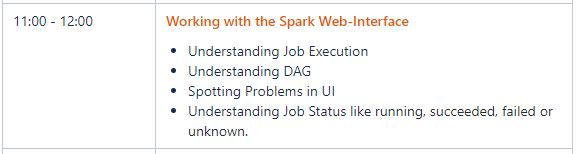

In [82]:
Image(filename="pics/d2_3.JPG")

Source:

https://databricks.com/blog/2015/06/22/understanding-your-spark-application-through-visualization.html

***spark-python/jupyter-advanced/02 - Caching Data - Skeleton.ipynb***



https://github.com/vivek-bombatkar/spark-training/blob/master/spark-python/jupyter-advanced/02%20-%20Caching%20Data%20-%20Skeleton.ipynb

***spark-python/jupyter-advanced/03 - Checkpointing - Skeleton.ipynb***

https://github.com/vivek-bombatkar/spark-training/blob/master/spark-python/jupyter-advanced/03%20-%20Checkpointing%20-%20Skeleton.ipynb


# Lunch Time

***Quiz / Food-For-Thought***: 


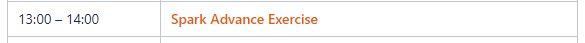

In [83]:
Image(filename="pics/d2_4.JPG")

# ***Hands-On session***


***spark-python/jupyter-advanced/04 - Broadcast Joins - Skeleton.ipynb***

https://github.com/vivek-bombatkar/spark-training/blob/master/spark-python/jupyter-advanced/04%20-%20Broadcast%20Joins%20-%20Skeleton.ipynb

***spark-python/jupyter-advanced/08 - Repartitioning - Skeleton.ipynb***

https://github.com/vivek-bombatkar/spark-training/blob/master/spark-python/jupyter-advanced/08%20-%20Repartitioning%20-%20Skeleton.ipynb

***spark-python/jupyter-advanced/09 - Bucketing - Skeleton.ipynb***

https://github.com/vivek-bombatkar/spark-training/blob/master/spark-python/jupyter-advanced/09%20-%20Bucketing%20-%20Skeleton.ipynb

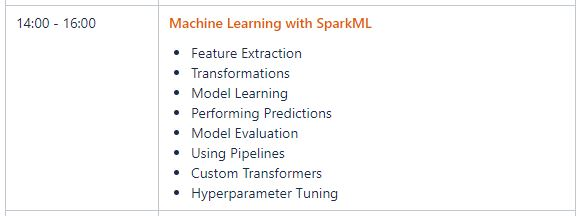

In [84]:
Image(filename="pics/d2_5.JPG")

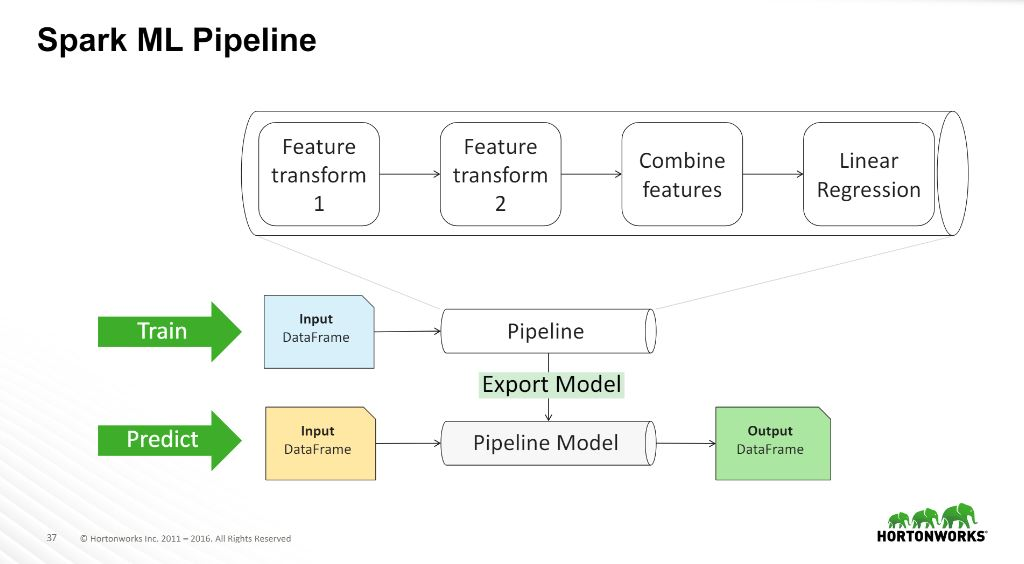

In [26]:
Image(filename="pics/d2_ml_1.JPG",width=800,height=500)

https://spark.apache.org/docs/latest/ml-pipeline.html

***Spark Mllib***

spark.mllib contains the legacy API built on top of RDDs.

***Spark ML***

spark.ml provides higher-level API built on top of DataFrames for constructing ML pipelines.

In [27]:
Image(url="https://github.com/vivek-bombatkar/DataWorksSummit2018_Spark_ML/raw/master/pics/LogisticRegression_HashingTF_Tokenizer_text_parsing_pipeline.jpg",width=1000,height=800)

In [28]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer

from pyspark.ml.classification import LogisticRegression



# Prepare training documents from a list of (id, text, label) tuples.
df_training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(df_training)


# Prepare test documents, which are unlabeled (id, text) tuples.
df_test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents and print columns of interest.
prediction = model.transform(df_test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

(4, spark i j k) --> prob=[0.15964077387874748,0.8403592261212525], prediction=1.000000
(5, l m n) --> prob=[0.8378325685476744,0.16216743145232562], prediction=0.000000
(6, spark hadoop spark) --> prob=[0.06926633132976032,0.9307336686702398], prediction=1.000000
(7, apache hadoop) --> prob=[0.9821575333444218,0.01784246665557808], prediction=0.000000


# ***Time to Hack!***

It's grate idea to hack together on very basic problem and learn through eachother experience...

Here is the hint...

-  Feature columns... 
-  Spark libs... 
-   

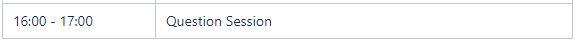

In [87]:
Image(filename="pics/d2_6.JPG")

# ***Bonus Session: Spark certification tips***: 


***Databricks Apache Spark Certification***  
https://www.linkedin.com/pulse/5-tips-cracking-databricks-apache-spark-certification-vivek-bombatkar?trk=portfolio_article-card_title
    
    
    
***Cloudera Certified Spark and Hadoop Developer***       
https://www.linkedin.com/pulse/why-what-how-cca-spark-hadoop-developer-exam-cca175-bombatkar?trk=portfolio_article-card_title

In [88]:
# Image(url="https://media.licdn.com/dms/image/C4D12AQEnwx58jX8mvg/article-cover_image-shrink_600_2000/0?e=1565827200&v=beta&t=jXX-5qIm0FtJaAvxY1j8tn56X40Dzk3qyUVVn4Wzdcc")
# Image(url="https://media.licdn.com/dms/image/C4D12AQGbKfyijL5Esw/article-cover_image-shrink_600_2000/0?e=1565827200&v=beta&t=B0N0rjmKqOYGvhSH99nRjdth0bwi9ncQoQyzhOWd22M")